# Package Import

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


# Data Exploration

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train_data = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/train_set.csv")
valid_data = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/valid_set.csv")
test_data = pd.read_csv("/kaggle/input/ys19-2023-assignment-3/test_set.csv")

print(train_data)

train_data.describe()

       New_ID                                               Text Sentiment  \
0       35027  #απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...   NEUTRAL   
1        9531  Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...  NEGATIVE   
2       14146  Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...  POSITIVE   
3       28716  @five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...   NEUTRAL   
4       32886  @ai_katerina Αυτό που είναι συγκλονιστικό είνα...   NEUTRAL   
...       ...                                                ...       ...   
36625   35374  @KourtakisJohn @kmitsotakis Ο Κούλης ο Μητσοτά...   NEUTRAL   
36626    7744  @enikos_gr @NChatzinikolaou @AdonisGeorgiadi Π...  NEGATIVE   
36627   35216  Η θέση του ΚΚΕ για την ασφάλεια των πολιτών κα...   NEUTRAL   
36628    2855  @thanosplevris Μαρη κακομοίρα θυγατέρα του ναζ...  NEGATIVE   
36629   25500  @gijjstalking @SpirosR76 Εντάξει με έπεισες! Κ...   NEUTRAL   

        Party  
0      SYRIZA  
1          ND  
2         KKE  

,New_ID
count,36630.000000
mean,18315.500000
std,10574.314517
min,1.000000
25%,9158.250000
50%,18315.500000
75%,27472.750000
max,36630.000000


# Data Preprocessing

Stemming

In [3]:
import re

__cases = dict()
__cases["ΦΑΓΙΑ"] = "ΦΑ"
__cases["ΦΑΓΙΟΥ"] = "ΦΑ"
__cases["ΦΑΓΙΩΝ"] = "ΦΑ"
__cases["ΣΚΑΓΙΑ"] = "ΣΚΑ"
__cases["ΣΚΑΓΙΟΥ"] = "ΣΚΑ"
__cases["ΣΚΑΓΙΩΝ"] = "ΣΚΑ"
__cases["ΟΛΟΓΙΟΥ"] = "ΟΛΟ"
__cases["ΟΛΟΓΙΑ"] = "ΟΛΟ"
__cases["ΟΛΟΓΙΩΝ"] = "ΟΛΟ"
__cases["ΣΟΓΙΟΥ"] = "ΣΟ"
__cases["ΣΟΓΙΑ"] = "ΣΟ"
__cases["ΣΟΓΙΩΝ"] = "ΣΟ"
__cases["ΤΑΤΟΓΙΑ"] = "ΤΑΤΟ"
__cases["ΤΑΤΟΓΙΟΥ"] = "ΤΑΤΟ"
__cases["ΤΑΤΟΓΙΩΝ"] = "ΤΑΤΟ"
__cases["ΚΡΕΑΣ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΟΣ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΑ"] = "ΚΡΕ"
__cases["ΚΡΕΑΤΩΝ"] = "ΚΡΕ"
__cases["ΠΕΡΑΣ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΟΣ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΑ"] = "ΠΕΡ"
__cases["ΠΕΡΑΤΩΝ"] = "ΠΕΡ"
__cases["ΤΕΡΑΣ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΟΣ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΑ"] = "ΤΕΡ"
__cases["ΤΕΡΑΤΩΝ"] = "ΤΕΡ"
__cases["ΦΩΣ"] = "ΦΩ"
__cases["ΦΩΤΟΣ"] = "ΦΩ"
__cases["ΦΩΤΑ"] = "ΦΩ"
__cases["ΦΩΤΩΝ"] = "ΦΩ"
__cases["ΚΑΘΕΣΤΩΣ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΟΣ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΑ"] = "ΚΑΘΕΣΤ"
__cases["ΚΑΘΕΣΤΩΤΩΝ"] = "ΚΑΘΕΣΤ"
__cases["ΓΕΓΟΝΟΣ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΟΣ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΑ"] = "ΓΕΓΟΝ"
__cases["ΓΕΓΟΝΟΤΩΝ"] = "ΓΕΓΟΝ"
__vowels = "[ΑΕΗΙΟΥΩ]"
__refinedVowels = "[ΑΕΗΙΟΩ]"


def stemWord(w: str, exceptions: dict = None):
    stem = None
    suffix = None
    test1 = True

    if exceptions is not None and w in exceptions.keys():
        return exceptions[w]

    if len(w) < 4:
        return w

    pattern = None
    pattern2 = None
    pattern3 = None
    pattern4 = None

    # Step1
    pattern = re.compile(
        r"(.*)(ΦΑΓΙΑ|ΦΑΓΙΟΥ|ΦΑΓΙΩΝ|ΣΚΑΓΙΑ|ΣΚΑΓΙΟΥ|ΣΚΑΓΙΩΝ|ΟΛΟΓΙΟΥ|ΟΛΟΓΙΑ|ΟΛΟΓΙΩΝ|ΣΟΓΙΟΥ|ΣΟΓΙΑ|ΣΟΓΙΩΝ|ΤΑΤΟΓΙΑ|ΤΑΤΟΓΙΟΥ|ΤΑΤΟΓΙΩΝ|ΚΡΕΑΣ|ΚΡΕΑΤΟΣ|ΚΡΕΑΤΑ|ΚΡΕΑΤΩΝ|ΠΕΡΑΣ|ΠΕΡΑΤΟΣ|ΠΕΡΑΤΑ|ΠΕΡΑΤΩΝ|ΤΕΡΑΣ|ΤΕΡΑΤΟΣ|ΤΕΡΑΤΑ|ΤΕΡΑΤΩΝ|ΦΩΣ|ΦΩΤΟΣ|ΦΩΤΑ|ΦΩΤΩΝ|ΚΑΘΕΣΤΩΣ|ΚΑΘΕΣΤΩΤΟΣ|ΚΑΘΕΣΤΩΤΑ|ΚΑΘΕΣΤΩΤΩΝ|ΓΕΓΟΝΟΣ|ΓΕΓΟΝΟΤΟΣ|ΓΕΓΟΝΟΤΑ|ΓΕΓΟΝΟΤΩΝ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        suffix = fp[1]
        w = stem + __cases[suffix]
        test1 = False

    # Step 2a
    pattern = re.compile(r"^(.+?)(ΑΔΕΣ|ΑΔΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        reg1 = re.compile(r"(ΟΚ|ΜΑΜ|ΜΑΝ|ΜΠΑΜΠ|ΠΑΤΕΡ|ΓΙΑΓΙ|ΝΤΑΝΤ|ΚΥΡ|ΘΕΙ|ΠΕΘΕΡ)$")

        if not reg1.match(w):
            w = w + "ΑΔ"

    # Step 2b
    pattern2 = re.compile(r"^(.+?)(ΕΔΕΣ|ΕΔΩΝ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        except2 = re.compile(r"(ΟΠ|ΙΠ|ΕΜΠ|ΥΠ|ΓΗΠ|ΔΑΠ|ΚΡΑΣΠ|ΜΙΛ)$")
        if except2.match(w):
            w = w + "ΕΔ"

    # Step 2c
    pattern3 = re.compile(r"^(.+?)(ΟΥΔΕΣ|ΟΥΔΩΝ)$")
    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        except3 = re.compile(r"(ΑΡΚ|ΚΑΛΙΑΚ|ΠΕΤΑΛ|ΛΙΧ|ΠΛΕΞ|ΣΚ|Σ|ΦΛ|ΦΡ|ΒΕΛ|ΛΟΥΛ|ΧΝ|ΣΠ|ΤΡΑΓ|ΦΕ)$")
        if except3.match(w):
            w = w + "ΟΥΔ"

    # Step 2d
    pattern4 = re.compile("^(.+?)(ΕΩΣ|ΕΩΝ)$")
    if pattern4.match(w):
        fp = pattern4.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except4 = re.compile(r"^(Θ|Δ|ΕΛ|ΓΑΛ|Ν|Π|ΙΔ|ΠΑΡ)$")
        if except4.match(w):
            w = w + "Ε"

    # Step 3
    pattern = re.compile(r"^(.+?)(ΙΑ|ΙΟΥ|ΙΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        pattern2 = re.compile(__vowels + "$")
        test1 = False
        if pattern2.match(w):
            w = stem + "Ι"

    # Step 4
    pattern = re.compile(r"^(.+?)(ΙΚΑ|ΙΚΟ|ΙΚΟΥ|ΙΚΩΝ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(__vowels + "$")
        except5 = re.compile(
            r"^(ΑΛ|ΑΔ|ΕΝΔ|ΑΜΑΝ|ΑΜΜΟΧΑΛ|ΗΘ|ΑΝΗΘ|ΑΝΤΙΔ|ΦΥΣ|ΒΡΩΜ|ΓΕΡ|ΕΞΩΔ|ΚΑΛΠ|ΚΑΛΛΙΝ|ΚΑΤΑΔ|ΜΟΥΛ|ΜΠΑΝ|ΜΠΑΓΙΑΤ|ΜΠΟΛ|ΜΠΟΣ|ΝΙΤ|ΞΙΚ|ΣΥΝΟΜΗΛ|ΠΕΤΣ|ΠΙΤΣ|ΠΙΚΑΝΤ|ΠΛΙΑΤΣ|ΠΟΣΤΕΛΝ|ΠΡΩΤΟΔ|ΣΕΡΤ|ΣΥΝΑΔ|ΤΣΑΜ|ΥΠΟΔ|ΦΙΛΟΝ|ΦΥΛΟΔ|ΧΑΣ)$")
        if except5.match(w) or pattern2.match(w):
            w = w + "ΙΚ"

    # step 5a
    pattern = re.compile(r"^(.+?)(ΑΜΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΑΓΑΜΕ|ΗΣΑΜΕ|ΟΥΣΑΜΕ|ΗΚΑΜΕ|ΗΘΗΚΑΜΕ)$")
    if w == "ΑΓΑΜΕ":
        w = "ΑΓΑΜ"

    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except6 = re.compile(r"^(ΑΝΑΠ|ΑΠΟΘ|ΑΠΟΚ|ΑΠΟΣΤ|ΒΟΥΒ|ΞΕΘ|ΟΥΛ|ΠΕΘ|ΠΙΚΡ|ΠΟΤ|ΣΙΧ|Χ)$")
        if except6.match(w):
            w = w + "ΑΜ"

    # Step 5b
    pattern2 = re.compile(r"^(.+?)(ΑΝΕ)$")
    pattern3 = re.compile(r"^(.+?)(ΑΓΑΝΕ|ΗΣΑΝΕ|ΟΥΣΑΝΕ|ΙΟΝΤΑΝΕ|ΙΟΤΑΝΕ|ΙΟΥΝΤΑΝΕ|ΟΝΤΑΝΕ|ΟΤΑΝΕ|ΟΥΝΤΑΝΕ|ΗΚΑΝΕ|ΗΘΗΚΑΝΕ)$")
    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern3 = re.compile(r"^(ΤΡ|ΤΣ)$")
        if pattern3.match(w):
            w = w + "ΑΓΑΝ"

    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(__refinedVowels + "$")
        except7 = re.compile(
            r"^(ΒΕΤΕΡ|ΒΟΥΛΚ|ΒΡΑΧΜ|Γ|ΔΡΑΔΟΥΜ|Θ|ΚΑΛΠΟΥΖ|ΚΑΣΤΕΛ|ΚΟΡΜΟΡ|ΛΑΟΠΛ|ΜΩΑΜΕΘ|Μ|ΜΟΥΣΟΥΛΜ|Ν|ΟΥΛ|Π|ΠΕΛΕΚ|ΠΛ|ΠΟΛΙΣ|ΠΟΡΤΟΛ|ΣΑΡΑΚΑΤΣ|ΣΟΥΛΤ|ΤΣΑΡΛΑΤ|ΟΡΦ|ΤΣΙΓΓ|ΤΣΟΠ|ΦΩΤΟΣΤΕΦ|Χ|ΨΥΧΟΠΛ|ΑΓ|ΟΡΦ|ΓΑΛ|ΓΕΡ|ΔΕΚ|ΔΙΠΛ|ΑΜΕΡΙΚΑΝ|ΟΥΡ|ΠΙΘ|ΠΟΥΡΙΤ|Σ|ΖΩΝΤ|ΙΚ|ΚΑΣΤ|ΚΟΠ|ΛΙΧ|ΛΟΥΘΗΡ|ΜΑΙΝΤ|ΜΕΛ|ΣΙΓ|ΣΠ|ΣΤΕΓ|ΤΡΑΓ|ΤΣΑΓ|Φ|ΕΡ|ΑΔΑΠ|ΑΘΙΓΓ|ΑΜΗΧ|ΑΝΙΚ|ΑΝΟΡΓ|ΑΠΗΓ|ΑΠΙΘ|ΑΤΣΙΓΓ|ΒΑΣ|ΒΑΣΚ|ΒΑΘΥΓΑΛ|ΒΙΟΜΗΧ|ΒΡΑΧΥΚ|ΔΙΑΤ|ΔΙΑΦ|ΕΝΟΡΓ|ΘΥΣ|ΚΑΠΝΟΒΙΟΜΗΧ|ΚΑΤΑΓΑΛ|ΚΛΙΒ|ΚΟΙΛΑΡΦ|ΛΙΒ|ΜΕΓΛΟΒΙΟΜΗΧ|ΜΙΚΡΟΒΙΟΜΗΧ|ΝΤΑΒ|ΞΗΡΟΚΛΙΒ|ΟΛΙΓΟΔΑΜ|ΟΛΟΓΑΛ|ΠΕΝΤΑΡΦ|ΠΕΡΗΦ|ΠΕΡΙΤΡ|ΠΛΑΤ|ΠΟΛΥΔΑΠ|ΠΟΛΥΜΗΧ|ΣΤΕΦ|ΤΑΒ|ΤΕΤ|ΥΠΕΡΗΦ|ΥΠΟΚΟΠ|ΧΑΜΗΛΟΔΑΠ|ΨΗΛΟΤΑΒ)$")
        if (pattern2.match(w)) or (except7.match(w)):
            w = w + "ΑΝ"

    # //Step 5c
    pattern3 = re.compile(r"^(.+?)(ΕΤΕ)$")
    pattern4 = re.compile(r"^(.+?)(ΗΣΕΤΕ)$")
    if pattern4.match(w):
        fp = pattern4.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern3.match(w):
        fp = pattern3.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern3 = re.compile(__refinedVowels + "$")
        except8 = re.compile(
            r"(ΟΔ|ΑΙΡ|ΦΟΡ|ΤΑΘ|ΔΙΑΘ|ΣΧ|ΕΝΔ|ΕΥΡ|ΤΙΘ|ΥΠΕΡΘ|ΡΑΘ|ΕΝΘ|ΡΟΘ|ΣΘ|ΠΥΡ|ΑΙΝ|ΣΥΝΔ|ΣΥΝ|ΣΥΝΘ|ΧΩΡ|ΠΟΝ|ΒΡ|ΚΑΘ|ΕΥΘ|ΕΚΘ|ΝΕΤ|ΡΟΝ|ΑΡΚ|ΒΑΡ|ΒΟΛ|ΩΦΕΛ)$")
        except9 = re.compile(
            r"^(ΑΒΑΡ|ΒΕΝ|ΕΝΑΡ|ΑΒΡ|ΑΔ|ΑΘ|ΑΝ|ΑΠΛ|ΒΑΡΟΝ|ΝΤΡ|ΣΚ|ΚΟΠ|ΜΠΟΡ|ΝΙΦ|ΠΑΓ|ΠΑΡΑΚΑΛ|ΣΕΡΠ|ΣΚΕΛ|ΣΥΡΦ|ΤΟΚ|Υ|Δ|ΕΜ|ΘΑΡΡ|Θ)$")
        if (pattern3.match(w)) or (except8.match(w)) or (except9.match(w)):
            w = w + "ΕΤ"

    # Step 5d
    pattern = re.compile(r"^(.+?)(ΟΝΤΑΣ|ΩΝΤΑΣ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except10 = re.compile(r"^(ΑΡΧ)$")
        except11 = re.compile(r"(ΚΡΕ)$")
        if except10.match(w):
            w = w + "ΟΝΤ"
        if except11.match(w):
            w = w + "ΩΝΤ"

    # Step 5e
    pattern = re.compile(r"^(.+?)(ΟΜΑΣΤΕ|ΙΟΜΑΣΤΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except11 = re.compile("^(ΟΝ)$")
        if except11.match(w):
            w = w + "ΟΜΑΣΤ"

    # Step 5f
    pattern = re.compile(r"^(.+?)(ΕΣΤΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΙΕΣΤΕ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        pattern2 = re.compile(r"^(Π|ΑΠ|ΣΥΜΠ|ΑΣΥΜΠ|ΑΚΑΤΑΠ|ΑΜΕΤΑΜΦ)$")
        if pattern2.match(w):
            w = w + "ΙΕΣΤ"

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except12 = re.compile(r"^(ΑΛ|ΑΡ|ΕΚΤΕΛ|Ζ|Μ|Ξ|ΠΑΡΑΚΑΛ|ΑΡ|ΠΡΟ|ΝΙΣ)$")
        if except12.match(w):
            w = w + "ΕΣΤ"

    # Step 5g
    pattern = re.compile(r"^(.+?)(ΗΚΑ|ΗΚΕΣ|ΗΚΕ)$")
    pattern2 = re.compile(r"^(.+?)(ΗΘΗΚΑ|ΗΘΗΚΕΣ|ΗΘΗΚΕ)$")
    if pattern2.match(w):
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except13 = re.compile(r"(ΣΚΩΛ|ΣΚΟΥΛ|ΝΑΡΘ|ΣΦ|ΟΘ|ΠΙΘ)$")
        except14 = re.compile(r"^(ΔΙΑΘ|Θ|ΠΑΡΑΚΑΤΑΘ|ΠΡΟΣΘ|ΣΥΝΘ|)$")
        if (except13.match(w)) or (except14.match(w)):
            w = w + "ΗΚ"

    # Step 5h
    pattern = re.compile(r"^(.+?)(ΟΥΣΑ|ΟΥΣΕΣ|ΟΥΣΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except15 = re.compile(
            r"^(ΦΑΡΜΑΚ|ΧΑΔ|ΑΓΚ|ΑΝΑΡΡ|ΒΡΟΜ|ΕΚΛΙΠ|ΛΑΜΠΙΔ|ΛΕΧ|Μ|ΠΑΤ|Ρ|Λ|ΜΕΔ|ΜΕΣΑΖ|ΥΠΟΤΕΙΝ|ΑΜ|ΑΙΘ|ΑΝΗΚ|ΔΕΣΠΟΖ|ΕΝΔΙΑΦΕΡ|ΔΕ|ΔΕΥΤΕΡΕΥ|ΚΑΘΑΡΕΥ|ΠΛΕ|ΤΣΑ)$")
        except16 = re.compile(r"(ΠΟΔΑΡ|ΒΛΕΠ|ΠΑΝΤΑΧ|ΦΡΥΔ|ΜΑΝΤΙΛ|ΜΑΛΛ|ΚΥΜΑΤ|ΛΑΧ|ΛΗΓ|ΦΑΓ|ΟΜ|ΠΡΩΤ)$")
        if (except15.match(w)) or (except16.match(w)):
            w = w + "ΟΥΣ"

    # Step 5i
    pattern = re.compile(r"^(.+?)(ΑΓΑ|ΑΓΕΣ|ΑΓΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except17 = re.compile(r"^(ΨΟΦ|ΝΑΥΛΟΧ)$")
        except20 = re.compile(r"(ΚΟΛΛ)$")
        except18 = re.compile(
            r"^(ΑΒΑΣΤ|ΠΟΛΥΦ|ΑΔΗΦ|ΠΑΜΦ|Ρ|ΑΣΠ|ΑΦ|ΑΜΑΛ|ΑΜΑΛΛΙ|ΑΝΥΣΤ|ΑΠΕΡ|ΑΣΠΑΡ|ΑΧΑΡ|ΔΕΡΒΕΝ|ΔΡΟΣΟΠ|ΞΕΦ|ΝΕΟΠ|ΝΟΜΟΤ|ΟΛΟΠ|ΟΜΟΤ|ΠΡΟΣΤ|ΠΡΟΣΩΠΟΠ|ΣΥΜΠ|ΣΥΝΤ|Τ|ΥΠΟΤ|ΧΑΡ|ΑΕΙΠ|ΑΙΜΟΣΤ|ΑΝΥΠ|ΑΠΟΤ|ΑΡΤΙΠ|ΔΙΑΤ|ΕΝ|ΕΠΙΤ|ΚΡΟΚΑΛΟΠ|ΣΙΔΗΡΟΠ|Λ|ΝΑΥ|ΟΥΛΑΜ|ΟΥΡ|Π|ΤΡ|Μ)$")
        except19 = re.compile(r"(ΟΦ|ΠΕΛ|ΧΟΡΤ|ΛΛ|ΣΦ|ΡΠ|ΦΡ|ΠΡ|ΛΟΧ|ΣΜΗΝ)$")
        if (except18.match(w) and except19.match(w)) and not ((except17.match(w)) or (except20.match(w))):
            w = w + "ΑΓ"

    # Step 5j
    pattern = re.compile("^(.+?)(ΗΣΕ|ΗΣΟΥ|ΗΣΑ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except21 = re.compile(r"^(Ν|ΧΕΡΣΟΝ|ΔΩΔΕΚΑΝ|ΕΡΗΜΟΝ|ΜΕΓΑΛΟΝ|ΕΠΤΑΝ)$")
        if except21.match(w):
            w = w + "ΗΣ"

    # Step 5k
    pattern = re.compile(r"^(.+?)(ΗΣΤΕ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except22 = re.compile(r"^(ΑΣΒ|ΣΒ|ΑΧΡ|ΧΡ|ΑΠΛ|ΑΕΙΜΝ|ΔΥΣΧΡ|ΕΥΧΡ|ΚΟΙΝΟΧΡ|ΠΑΛΙΜΨ)$")
        if except22.match(w):
            w = w + "ΗΣΤ"

    # Step 5l
    pattern = re.compile("^(.+?)(ΟΥΝΕ|ΗΣΟΥΝΕ|ΗΘΟΥΝΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except23 = re.compile("^(Ν|Ρ|ΣΠΙ|ΣΤΡΑΒΟΜΟΥΤΣ|ΚΑΚΟΜΟΥΤΣ|ΕΞΩΝ)$")
        if except23.match(w):
            w = w + "ΟΥΝ"

    # Step 5l
    pattern = re.compile(r"^(.+?)(ΟΥΜΕ|ΗΣΟΥΜΕ|ΗΘΟΥΜΕ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem
        test1 = False
        except24 = re.compile(r"^(ΠΑΡΑΣΟΥΣ|Φ|Χ|ΩΡΙΟΠΛ|ΑΖ|ΑΛΛΟΣΟΥΣ|ΑΣΟΥΣ)$")
        if except24.match(w):
            w = w + "ΟΥΜ"

    # Step 6
    pattern = re.compile(r"^(.+?)(ΜΑΤΑ|ΜΑΤΩΝ|ΜΑΤΟΣ)$")
    pattern2 = re.compile(
        r"^(.+?)(Α|ΑΓΑΤΕ|ΑΓΑΝ|ΑΕΙ|ΑΜΑΙ|ΑΝ|ΑΣ|ΑΣΑΙ|ΑΤΑΙ|ΑΩ|Ε|ΕΙ|ΕΙΣ|ΕΙΤΕ|ΕΣΑΙ|ΕΣ|ΕΤΑΙ|Ι|ΙΕΜΑΙ|ΙΕΜΑΣΤΕ|ΙΕΤΑΙ|ΙΕΣΑΙ|ΙΕΣΑΣΤΕ|ΙΟΜΑΣΤΑΝ|ΙΟΜΟΥΝ|ΙΟΜΟΥΝΑ|ΙΟΝΤΑΝ|ΙΟΝΤΟΥΣΑΝ|ΙΟΣΑΣΤΑΝ|ΙΟΣΑΣΤΕ|ΙΟΣΟΥΝ|ΙΟΣΟΥΝΑ|ΙΟΤΑΝ|ΙΟΥΜΑ|ΙΟΥΜΑΣΤΕ|ΙΟΥΝΤΑΙ|ΙΟΥΝΤΑΝ|Η|ΗΔΕΣ|ΗΔΩΝ|ΗΘΕΙ|ΗΘΕΙΣ|ΗΘΕΙΤΕ|ΗΘΗΚΑΤΕ|ΗΘΗΚΑΝ|ΗΘΟΥΝ|ΗΘΩ|ΗΚΑΤΕ|ΗΚΑΝ|ΗΣ|ΗΣΑΝ|ΗΣΑΤΕ|ΗΣΕΙ|ΗΣΕΣ|ΗΣΟΥΝ|ΗΣΩ|Ο|ΟΙ|ΟΜΑΙ|ΟΜΑΣΤΑΝ|ΟΜΟΥΝ|ΟΜΟΥΝΑ|ΟΝΤΑΙ|ΟΝΤΑΝ|ΟΝΤΟΥΣΑΝ|ΟΣ|ΟΣΑΣΤΑΝ|ΟΣΑΣΤΕ|ΟΣΟΥΝ|ΟΣΟΥΝΑ|ΟΤΑΝ|ΟΥ|ΟΥΜΑΙ|ΟΥΜΑΣΤΕ|ΟΥΝ|ΟΥΝΤΑΙ|ΟΥΝΤΑΝ|ΟΥΣ|ΟΥΣΑΝ|ΟΥΣΑΤΕ|Υ|ΥΣ|Ω|ΩΝ)$")

    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem + "ΜΑ"

    if pattern2.match(w) and test1:
        fp = pattern2.match(w).groups()
        stem = fp[0]
        w = stem

    # Step 7 (ΠΑΡΑΘΕΤΙΚΑ)
    pattern = re.compile(r"^(.+?)(ΕΣΤΕΡ|ΕΣΤΑΤ|ΟΤΕΡ|ΟΤΑΤ|ΥΤΕΡ|ΥΤΑΤ|ΩΤΕΡ|ΩΤΑΤ)$")
    if pattern.match(w):
        fp = pattern.match(w).groups()
        stem = fp[0]
        w = stem

    return w

Cleaning, tokenization and lowercasing

In [4]:
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

# text normilization (used for removal of acute accents)
def strip_accents(text):
   return ''.join(c for c in unicodedata.normalize('NFD', text)
                  if unicodedata.category(c) != 'Mn')

# load Greek stopwords from the gr_stopwords.txt which was created by a fellow classmate
stopwords_path = '/kaggle/input/gr-stopwords/gr_stopwords.txt'
with open(stopwords_path, 'r', encoding='utf-8') as file:
    gr_stopwords = set(file.read().splitlines())

# text processing
def preprocess_text(text):
    # remove links and tags
    text = re.sub(r"http\S+|www\S+|@[^\s]+", ' ', text)
    
    # remove acute accents from Greek vowels
    text = strip_accents(text)
    
    # remove special characters
    text = re.sub(r"[^A-Za-z0-9Α-Ωα-ω]+", ' ', text)
    
#     return text
    
    # tokenize the text
    tokens = word_tokenize(text)
    
    # uppercasing
    tokens = [token.upper() for token in tokens]
    
    # stopwords removal
    tokens = [token for token in tokens if token not in gr_stopwords]
    
    # stemming
    tokens = [stemWord(token) for token in tokens]
    
    return ' '.join(tokens)

train_data['Processed_Text'] = train_data['Text'].apply(preprocess_text)
valid_data['Processed_Text'] = valid_data['Text'].apply(preprocess_text)
test_data['Processed_Text'] = test_data['Text'].apply(preprocess_text)

# convert sentiment labels to numerical format
label_encoder = LabelEncoder()
train_data['Sentiment'] = label_encoder.fit_transform(train_data['Sentiment'])
valid_data['Sentiment'] = label_encoder.fit_transform(valid_data['Sentiment'])
print(train_data)

       New_ID                                               Text  Sentiment  \
0       35027  #απολυμανση_κοριοι #απεντομωση_κοριος #απολυμα...          1   
1        9531  Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη...          0   
2       14146  Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στου...          2   
3       28716  @five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25...          1   
4       32886  @ai_katerina Αυτό που είναι συγκλονιστικό είνα...          1   
...       ...                                                ...        ...   
36625   35374  @KourtakisJohn @kmitsotakis Ο Κούλης ο Μητσοτά...          1   
36626    7744  @enikos_gr @NChatzinikolaou @AdonisGeorgiadi Π...          0   
36627   35216  Η θέση του ΚΚΕ για την ασφάλεια των πολιτών κα...          1   
36628    2855  @thanosplevris Μαρη κακομοίρα θυγατέρα του ναζ...          0   
36629   25500  @gijjstalking @SpirosR76 Εντάξει με έπεισες! Κ...          1   

        Party                                     P

# Analysis

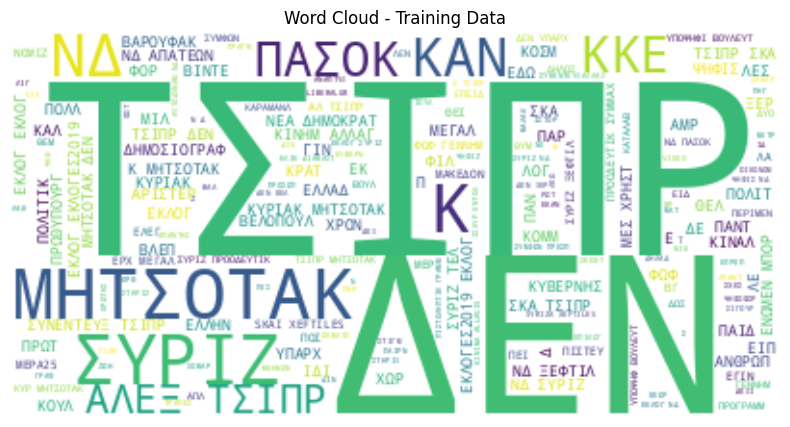

In [5]:
from wordcloud import WordCloud

# generate word clouds graph
def generate_word_cloud(text, title):
    wordcloud = WordCloud(background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(' '.join(train_data['Processed_Text']), 'Word Cloud - Training Data')

# Word Embeddings

In [6]:
from gensim.models import Word2Vec

# split each tweet into a list of words
sentences = [tweet.split() for tweet in train_data['Processed_Text']]

# train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# save or load the trained model for later use
word2vec_model.save("word2vec_model.bin")
# word2vec_model = Word2Vec.load("word2vec_model.bin") #if I want to load the model later

# # combine the processed text from train, validation, and test sets to train the word2vec model
# combined_text = pd.concat([train_data['Processed_Text'], 
#                           valid_data['Processed_Text'], 
#                           test_data['Processed_Text']])

# # split each tweet into a list of words
# tokenized_text = [text.split() for text in combined_text]

# # train Word2Vec model
# word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# # save Word2Vec model
# word2vec_model.save('word2vec_model.model')

And tensors

In [7]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, word2vec_model, train=True):
        self.data = data
        self.word2vec_model = word2vec_model.wv  # Access the KeyedVectors object
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        tweet = self.data.iloc[index]['Processed_Text']
        embeddings = self.text_to_embeddings(tweet)

        # Convert embeddings to tensor
        embeddings = self.embeddings_to_tensor(embeddings)

        if self.train:
            sentiment = self.data.iloc[index]['Sentiment']
            return embeddings, sentiment
        else:
            return embeddings

    def text_to_embeddings(self, text):
        embeddings = []
        for word in text.split():
            if word in self.word2vec_model:
                embeddings.append(self.word2vec_model[word])
            else:
                # Handle out-of-vocabulary words (e.g., by skipping them or replacing them with a special token)
                pass
        return embeddings

    def embeddings_to_tensor(self, embeddings):
        if embeddings:
            embeddings = np.array(embeddings)  # Convert list of arrays to a single NumPy array
            embeddings = torch.tensor(embeddings, dtype=torch.float)  # Convert NumPy array to tensor
        else:
            # Handle empty embeddings list (e.g., by skipping the tweet or replacing with a placeholder value)
            embeddings = torch.zeros((1, len(self.word2vec_model[0])), dtype=torch.float)

        # Pad or truncate embeddings to a fixed length
        max_length = 100  # You can choose a suitable max length based on your data
        if len(embeddings) < max_length:
            pad_tensor = torch.zeros((max_length - len(embeddings), len(embeddings[0])))
            embeddings = torch.cat((embeddings, pad_tensor))
        else:
            embeddings = embeddings[:max_length]

        return embeddings
    
BATCH_SIZE = 64

# Create training dataset and data loader
train_dataset = CustomDataset(train_data, word2vec_model, train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create validation dataset and data loader
valid_dataset = CustomDataset(valid_data, word2vec_model, train=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create test dataset and data loader
test_dataset = CustomDataset(test_data, word2vec_model, train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the sentiment classifier model

In [8]:
class SentimentRNN(nn.Module):
    """
    Wrapper module for RNN, LSTM, GRU cells using PyTorch API. The output is fed to a FFN for classification.
    """
    def __init__(self, cell_type, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super(SentimentRNN, self).__init__()

        cells = {
            "RNN": nn.RNN,
            "LSTM": nn.LSTM,
            "GRU": nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,  # Dropout between layers if applicable
        )

        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (num_layers, batch, hidden_size)
        
        if self.cell_type == 'LSTM':
            r_out, (h_n, _) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

And initialize it

In [9]:
# Configuration
input_size = 100
hidden_size = 64
output_size = 3  # 3 classes: POSITIVE, NEUTRAL, NEGATIVE
cell_type = 'LSTM'
num_layers = 2
dropout = 0.2

# Initialize the model
net = SentimentRNN(cell_type, input_size, hidden_size, output_size, num_layers, dropout)
print(net)

SentimentRNN(
  (rnn): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.2)
  (out): Linear(in_features=64, out_features=3, bias=True)
)


# Train and test the model

In [10]:
# Define hyperparameters
EPOCHS = 5
LR = 0.001

# Define optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

Epoch [1/5], Step [50/573], Loss: 1.0963, Accuracy: 0.3594
Epoch [1/5], Step [100/573], Loss: 1.1001, Accuracy: 0.2656
Epoch [1/5], Step [150/573], Loss: 1.0959, Accuracy: 0.3906
Epoch [1/5], Step [200/573], Loss: 1.0996, Accuracy: 0.3438
Epoch [1/5], Step [250/573], Loss: 1.1013, Accuracy: 0.3125
Epoch [1/5], Step [300/573], Loss: 1.1020, Accuracy: 0.2188
Epoch [1/5], Step [350/573], Loss: 1.1028, Accuracy: 0.2188
Epoch [1/5], Step [400/573], Loss: 1.0973, Accuracy: 0.3750
Epoch [1/5], Step [450/573], Loss: 1.1011, Accuracy: 0.3125
Epoch [1/5], Step [500/573], Loss: 1.0933, Accuracy: 0.4062
Epoch [1/5], Step [550/573], Loss: 1.0999, Accuracy: 0.3125
Epoch [2/5], Step [27/573], Loss: 1.0996, Accuracy: 0.3750
Epoch [2/5], Step [77/573], Loss: 1.1009, Accuracy: 0.2656
Epoch [2/5], Step [127/573], Loss: 1.0995, Accuracy: 0.3438
Epoch [2/5], Step [177/573], Loss: 1.0998, Accuracy: 0.2812
Epoch [2/5], Step [227/573], Loss: 1.0990, Accuracy: 0.3281
Epoch [2/5], Step [277/573], Loss: 1.0979, 

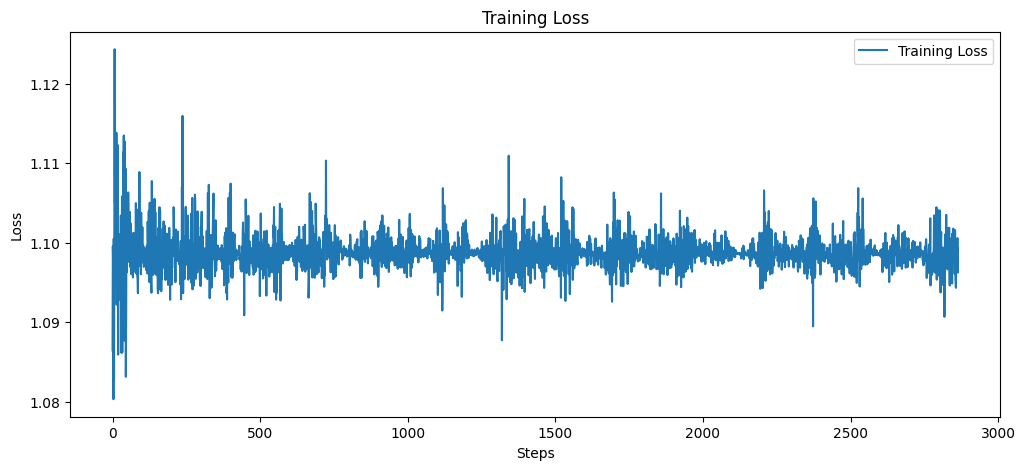

In [11]:
import torch.nn.functional as F

# Start training mode
net.train()

# Lists to store training losses and accuracies
train_losses = []
train_accuracies = []

# Lists to store validation losses and accuracies
valid_losses = []
valid_accuracies = []

# Count the number of batches processed
step_count = 0

# Evaluate the progress every # batches
print_every = 50

# Training loop
for epoch in range(EPOCHS):

    for step, (inputs, labels) in enumerate(train_loader):

        # Clear gradients for this training step
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = net(inputs)

        # Calculate the loss
        loss = loss_func(outputs, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Record training loss
        train_losses.append(loss.item())

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        train_accuracies.append(accuracy)

        # Increment step count
        step_count += 1

        # Print training progress every print_every steps
        if step_count % print_every == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

# Plotting the training loss
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model evaluation

In [12]:
EPOCHS = 5

# Lists to store validation losses and accuracies
valid_losses = []
valid_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0
    
    for step, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Record training loss and accuracy
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        epoch_train_accuracy += accuracy
        
        # Print training progress every print_every steps
        if step_count % print_every == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    # Calculate average training loss and accuracy for the epoch
    epoch_train_loss /= len(train_loader)
    epoch_train_accuracy /= len(train_loader)
    
    # Validate the model
    net.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency
        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0
        
        for inputs, labels in valid_loader:
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            epoch_valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            epoch_valid_accuracy += accuracy
        
        # Calculate average validation loss and accuracy for the epoch
        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy /= len(valid_loader)
        
        # Print validation statistics
        print(f"Epoch [{epoch+1}/{EPOCHS}], Validation Loss: {epoch_valid_loss:.4f}, "
              f"Validation Accuracy: {epoch_valid_accuracy:.4f}")
        
        # Store validation losses and accuracies for later visualization
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)
        
    # Switch back to training mode
    net.train()

Epoch [1/5], Validation Loss: 1.0987, Validation Accuracy: 0.3334
Epoch [2/5], Validation Loss: 1.0986, Validation Accuracy: 0.3331
Epoch [3/5], Validation Loss: 1.0987, Validation Accuracy: 0.3335
Epoch [4/5], Validation Loss: 1.0986, Validation Accuracy: 0.3334
Epoch [5/5], Validation Loss: 1.0986, Validation Accuracy: 0.3336


Validation Accuracy: 33.33%


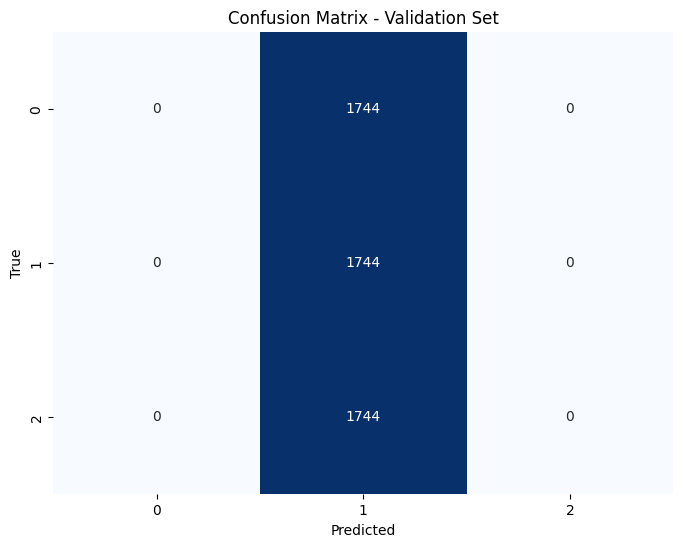

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1744
           1       0.33      1.00      0.50      1744
           2       1.00      0.00      0.00      1744

    accuracy                           0.33      5232
   macro avg       0.78      0.33      0.17      5232
weighted avg       0.78      0.33      0.17      5232



In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# Validation
net.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for efficiency
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    for inputs, labels in valid_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predicted and true labels for evaluation
        all_predicted.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

    # Calculate validation accuracy
    valid_accuracy = correct / total
    print(f'Validation Accuracy: {valid_accuracy:.2%}')

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Validation Set")
    plt.show()

    # Calculate precision, recall, and F1-score
    report = classification_report(all_labels, all_predicted, zero_division=1)
    print("Classification Report:")
    print(report)

# Experiments

After multiple tests testing many different configurations here's the parameters that yield the best results in the model's current state that I could manually find:

In [14]:
# Define and initialize the model with different hyperparameters
net = SentimentRNN(cell_type='LSTM',
                    input_size=input_size,
                    hidden_size=128,
                    output_size=output_size,
                    num_layers=2,
                    dropout=0.1)

# Define hyperparameters
EPOCHS = 1  # Number of epochs
LR = 0.001  # Learning rate

# Define optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

# Lists to store training and validation losses and accuracies
train_losses = []
valid_losses = []
valid_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    # Set model to training mode
    net.train()
    
    # Track epoch loss
    epoch_train_loss = 0.0
    
    # Training
    for step, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear gradients
        
        # Forward pass
        outputs = net(inputs)
        
        # Calculate loss
        loss = loss_func(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Validation
    net.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency
        epoch_valid_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            epoch_valid_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for the epoch
        epoch_valid_loss /= len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        valid_accuracy = correct / total
        valid_accuracies.append(valid_accuracy)
    
    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{EPOCHS}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2%}")

Epoch [1/1], Training Loss: 1.0990, Validation Loss: 1.0990, Validation Accuracy: 33.33%


# Hyperparameter tuning

In [15]:
%pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [16]:
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate

def objective(trial):
    # Define hyperparameters to optimize
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    dropout = trial.suggest_float('dropout', 0.0, 0.5) if num_layers > 1 else 0.0
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    cell_type = trial.suggest_categorical('cell_type', ['LSTM', 'GRU'])
    
    # Reinitialize the model with new hyperparameters
    net = SentimentRNN(cell_type, input_size, hidden_size, output_size, num_layers, dropout)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_func = nn.CrossEntropyLoss()
    
    # Start training mode
    net.train()
    
    # Training loop
    for epoch in range(EPOCHS):
        for step, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluation mode
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
    
    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Visualize optimization history
plot_optimization_history(study)

# Visualize parallel coordinate plot
plot_parallel_coordinate(study)

[I 2024-02-13 20:35:49,592] A new study created in memory with name: no-name-1b0af2d6-36c2-4307-86eb-4cf56603962f
[I 2024-02-13 20:39:18,287] Trial 0 finished with value: 0.3333333333333333 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.465887131945871, 'lr': 0.0023374545254059467, 'cell_type': 'GRU'}. Best is trial 0 with value: 0.3333333333333333.
[I 2024-02-13 20:40:13,152] Trial 1 finished with value: 0.3333333333333333 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 1.3045023407310764e-05, 'cell_type': 'GRU'}. Best is trial 0 with value: 0.3333333333333333.
[I 2024-02-13 20:42:37,376] Trial 2 finished with value: 0.3333333333333333 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.423685041616176, 'lr': 0.004334307757954343, 'cell_type': 'GRU'}. Best is trial 0 with value: 0.3333333333333333.
[I 2024-02-13 20:44:28,844] Trial 3 finished with value: 0.3333333333333333 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.0

Re-evaluate after hyperparameter tuning..

In [17]:
# Define and initialize the model with the best hyperparameters
net = SentimentRNN(cell_type='GRU',
                    input_size=input_size,
                    hidden_size=128,
                    output_size=output_size,
                    num_layers=2,
                    dropout=0.16)

EPOCHS = 5
LR = 0.007

# Define optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

# Lists to store validation losses and accuracies
valid_losses = []
valid_accuracies = []

# Training loop
for epoch in range(EPOCHS):
    epoch_train_loss = 0.0
    epoch_train_accuracy = 0.0
    
    for step, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Record training loss and accuracy
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        epoch_train_accuracy += accuracy
        
        # Print training progress every print_every steps
        if step_count % print_every == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{step+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    # Calculate average training loss and accuracy for the epoch
    epoch_train_loss /= len(train_loader)
    epoch_train_accuracy /= len(train_loader)
    
    # Validate the model
    net.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency
        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0
        
        for inputs, labels in valid_loader:
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            epoch_valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            epoch_valid_accuracy += accuracy
        
        # Calculate average validation loss and accuracy for the epoch
        epoch_valid_loss /= len(valid_loader)
        epoch_valid_accuracy /= len(valid_loader)
        
        # Print validation statistics
        print(f"Epoch [{epoch+1}/{EPOCHS}], Validation Loss: {epoch_valid_loss:.4f}, "
              f"Validation Accuracy: {epoch_valid_accuracy:.4f}")
        
        # Store validation losses and accuracies for later visualization
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_accuracy)
        
    # Switch back to training mode
    net.train()

Epoch [1/5], Validation Loss: 1.1146, Validation Accuracy: 0.3331
Epoch [2/5], Validation Loss: 1.1011, Validation Accuracy: 0.3335
Epoch [3/5], Validation Loss: 1.0929, Validation Accuracy: 0.3537
Epoch [4/5], Validation Loss: 1.1014, Validation Accuracy: 0.3561
Epoch [5/5], Validation Loss: 1.0885, Validation Accuracy: 0.3518


# Output predictions

In [18]:
# Lists to store predictions and IDs
test_predictions = []
test_ids = []

# Set model to evaluation mode
net.eval()

# Disable gradient calculation for efficiency
with torch.no_grad():
    for inputs in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions.extend(predicted.tolist())

        # Extract tweet IDs from the test dataset
        test_ids.extend(inputs[:, 0].tolist())  # Assuming the first column contains IDs

# Add the predicted sentiment column to the test_data dataframe
test_data['Sentiment'] = test_predictions

# Convert encoded predictions back to sentiment labels
predicted_labels = label_encoder.inverse_transform(test_predictions)

# Create a new dataframe with only the necessary columns for output
submission_data = pd.DataFrame({'Id': test_data['New_ID'], 'Predicted': predicted_labels})

# Visualize results
print(submission_data)

# Save the dataframe to a CSV file
submission_data.to_csv('submission.csv', index=False)

          Id Predicted
0          1   NEUTRAL
1          2  POSITIVE
2          3  POSITIVE
3          4   NEUTRAL
4          5   NEUTRAL
...      ...       ...
10465  10466   NEUTRAL
10466  10467   NEUTRAL
10467  10468   NEUTRAL
10468  10469   NEUTRAL
10469  10470   NEUTRAL

[10470 rows x 2 columns]
